In [1]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
from feature_set_v2 import MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier


In [2]:
# import importlib
# import feature_25 
# importlib.reload(feature_25)


In [3]:
# ============ 2) The Cross-Validation Function ============

def rolling_time_series_cv_sjm_long_short(
    lam,
    kappa,
    X,
    factor_returns,
    market_returns,
    n_splits=5,
    initial_train_size=5*252,
    val_size=252,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Your original rolling expanding-window CV function. For each fold, it clips/scales,
    fits a SparseJumpModel, does day-lag logic, and returns a single Sharpe.
    We then average across folds.
    """
    n_samples = len(X)
    max_folds = (n_samples - initial_train_size) // val_size
    actual_folds = min(n_splits, max_folds)

    max_feats = int(kappa**2)
    sharpe_scores = []

    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        if ann_ret > threshold: 
            return 1.0
        elif ann_ret < -threshold: 
            return -1.0
        else: 
            return ann_ret / threshold

    start_of_val = initial_train_size

    for fold_i in range(actual_folds):
        train_end = start_of_val
        val_end = start_of_val + val_size
        if val_end > n_samples:
            val_end = n_samples

        # 1) Raw slices
        X_train_cv_raw = X.iloc[:train_end]
        y_train_cv     = factor_returns.iloc[:train_end]
        m_train_cv     = market_returns.iloc[:train_end]

        X_val_cv_raw   = X.iloc[train_end:val_end]
        y_val_cv       = factor_returns.iloc[train_end:val_end]
        m_val_cv       = market_returns.iloc[train_end:val_end]

        print(f"Fold {fold_i+1}: Train=[0:{train_end}], Val=[{train_end}:{val_end}]")

        # 2) Clipper/scaler on training portion only
        clipper_fold = DataClipperStd(mul=3.)
        X_train_cv_raw_clipped = clipper_fold.fit_transform(X_train_cv_raw)
        X_val_cv_raw_clipped   = clipper_fold.transform(X_val_cv_raw)

        scaler_fold = StandardScaler()
        X_train_cv = scaler_fold.fit_transform(X_train_cv_raw_clipped)
        X_val_cv   = scaler_fold.transform(X_val_cv_raw_clipped)

        # 3) Fit SJM
        model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats,
            jump_penalty=lam,
            cont=False,
            max_iter=30
        )
        model.fit(X_train_cv, ret_ser=y_train_cv, sort_by="cumret") ###################################### added ret_ser=y_train_cv to clarify, before was only y_train_cv. if error comes up this is likely it

        # 4) Regime inference on validation
        val_states = model.predict_online(X_val_cv)

        # 5) Evaluate strategy: day-lag logic
        val_active_ret = y_val_cv - m_val_cv
        strategy_ret = np.zeros(len(val_states))
        prev_position = 0.0

        # Compute expected return per regime from training
        state_avg_daily_ret = model.ret_
        avg_mkt_ret = m_train_cv.mean()
        state_to_expected = {
            st: (state_avg_daily_ret[st] - avg_mkt_ret)*252
            for st in range(len(state_avg_daily_ret))
        }

        for t in range(len(val_states)):
            daily_pnl = prev_position * val_active_ret.iloc[t]
            st = val_states[t]
            new_position = position_from_expected_return(state_to_expected.get(st,0.0))
            turnover = abs(new_position - prev_position)*2.0
            cost = turnover * cost_per_100pct
            strategy_ret[t] = daily_pnl - cost
            prev_position = new_position

        avg_ret = np.mean(strategy_ret)
        std_ret = np.std(strategy_ret, ddof=1)
        val_sharpe = 0.0 if std_ret==0 else (avg_ret/std_ret)*np.sqrt(252)

        sharpe_scores.append(val_sharpe)
        start_of_val += val_size  # expand window for next fold

    return np.mean(sharpe_scores)


Running SJM cross-validation for factor = iwf
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[iwf] Best Jump Penalty (λ): 93.63292088239417
[iwf] Best Max Features (κ²): 5
[iwf] Sharpe with best hyperparams: 0.1940215170408684


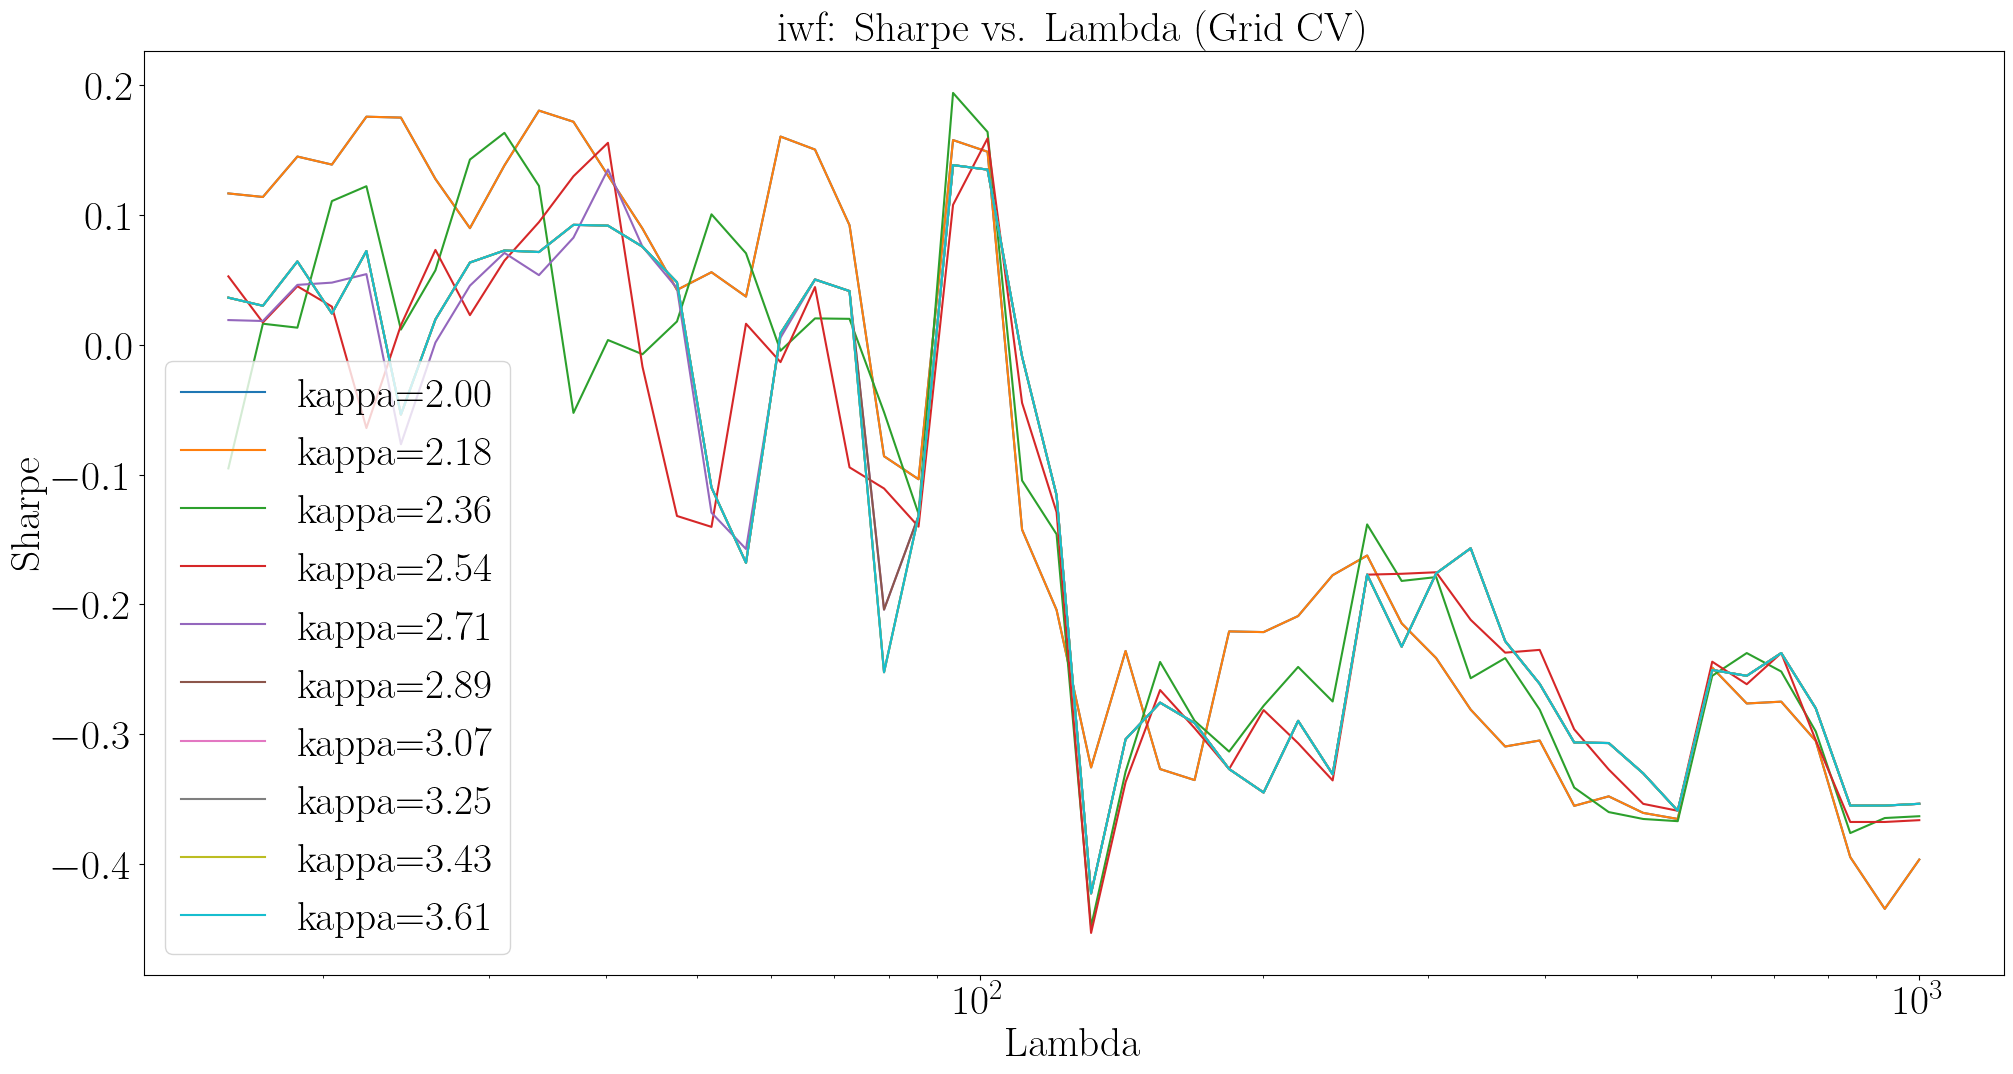

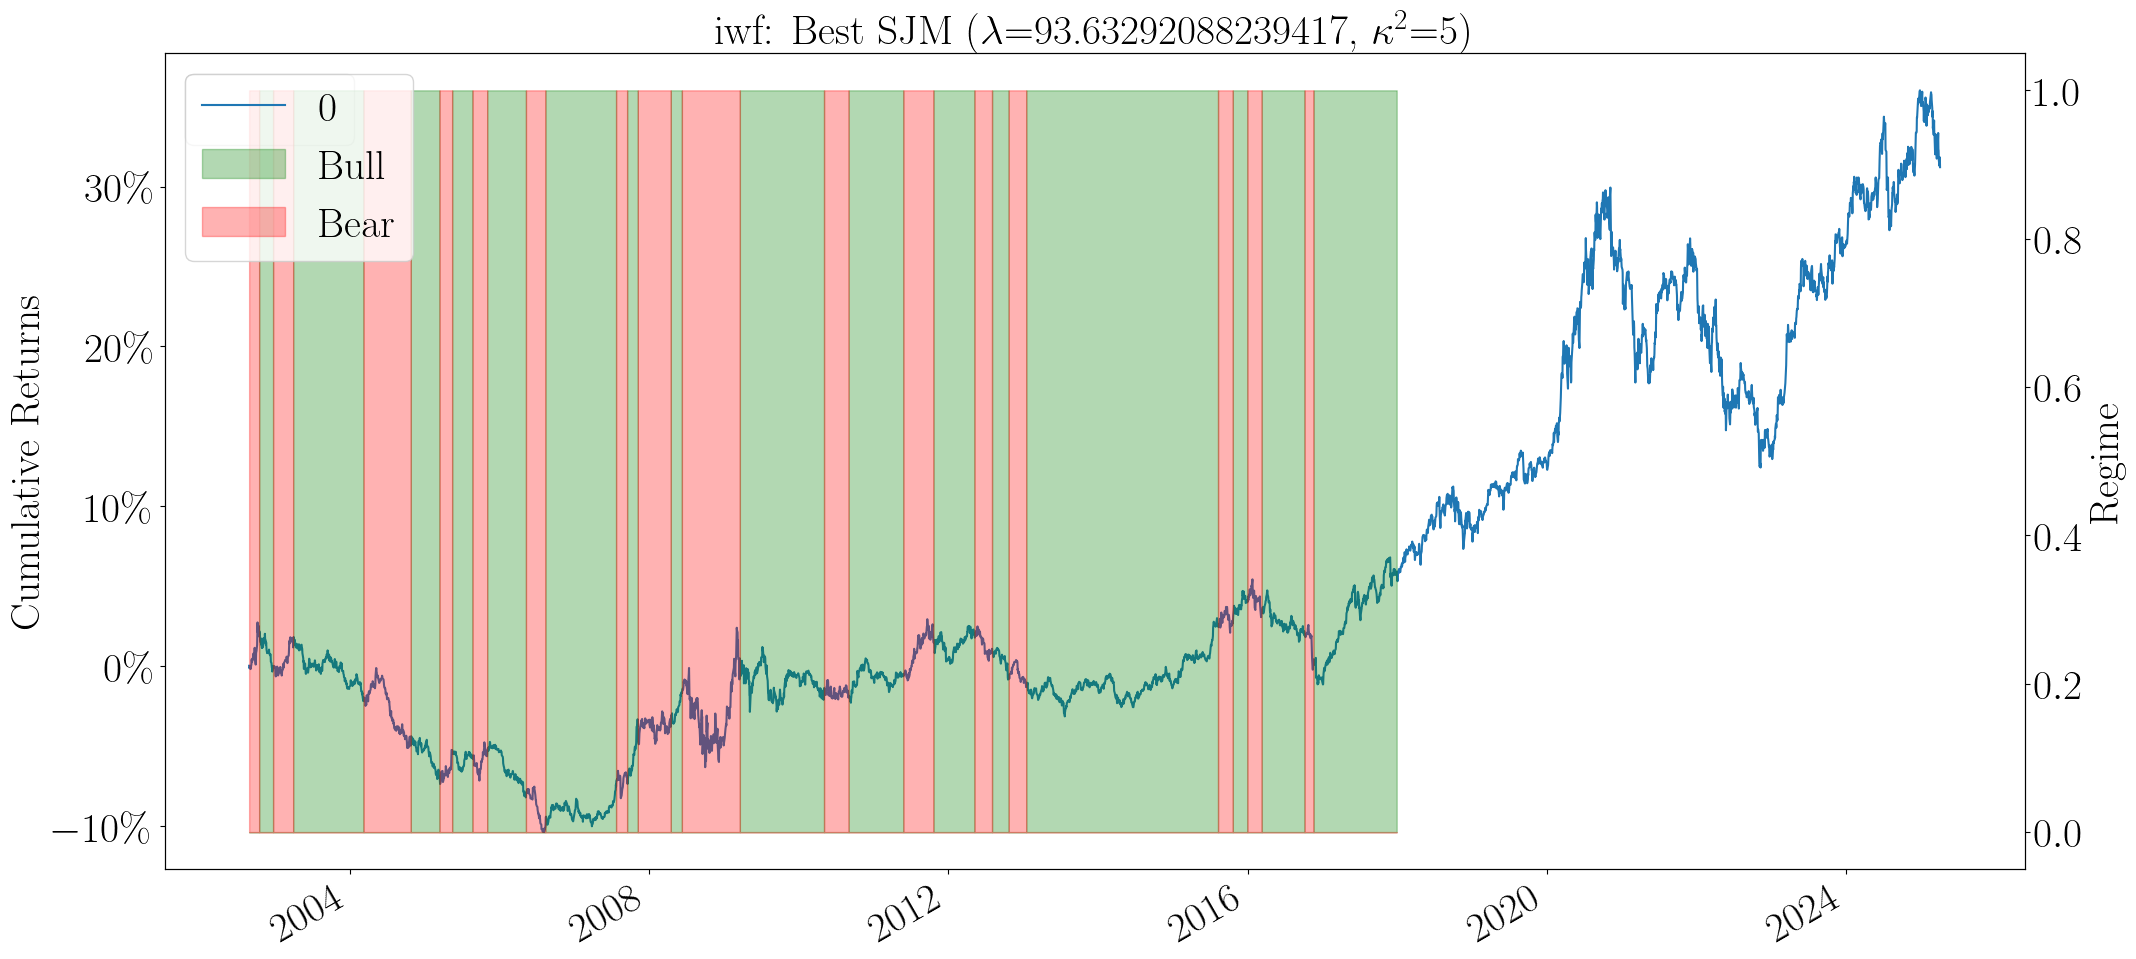


Running SJM cross-validation for factor = mtum
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[mtum] Best Jump Penalty (λ): 72.6481383605727
[mtum] Best Max Features (κ²): 5
[mtum] Sharpe with best hyperparams: 0.8527674238412294


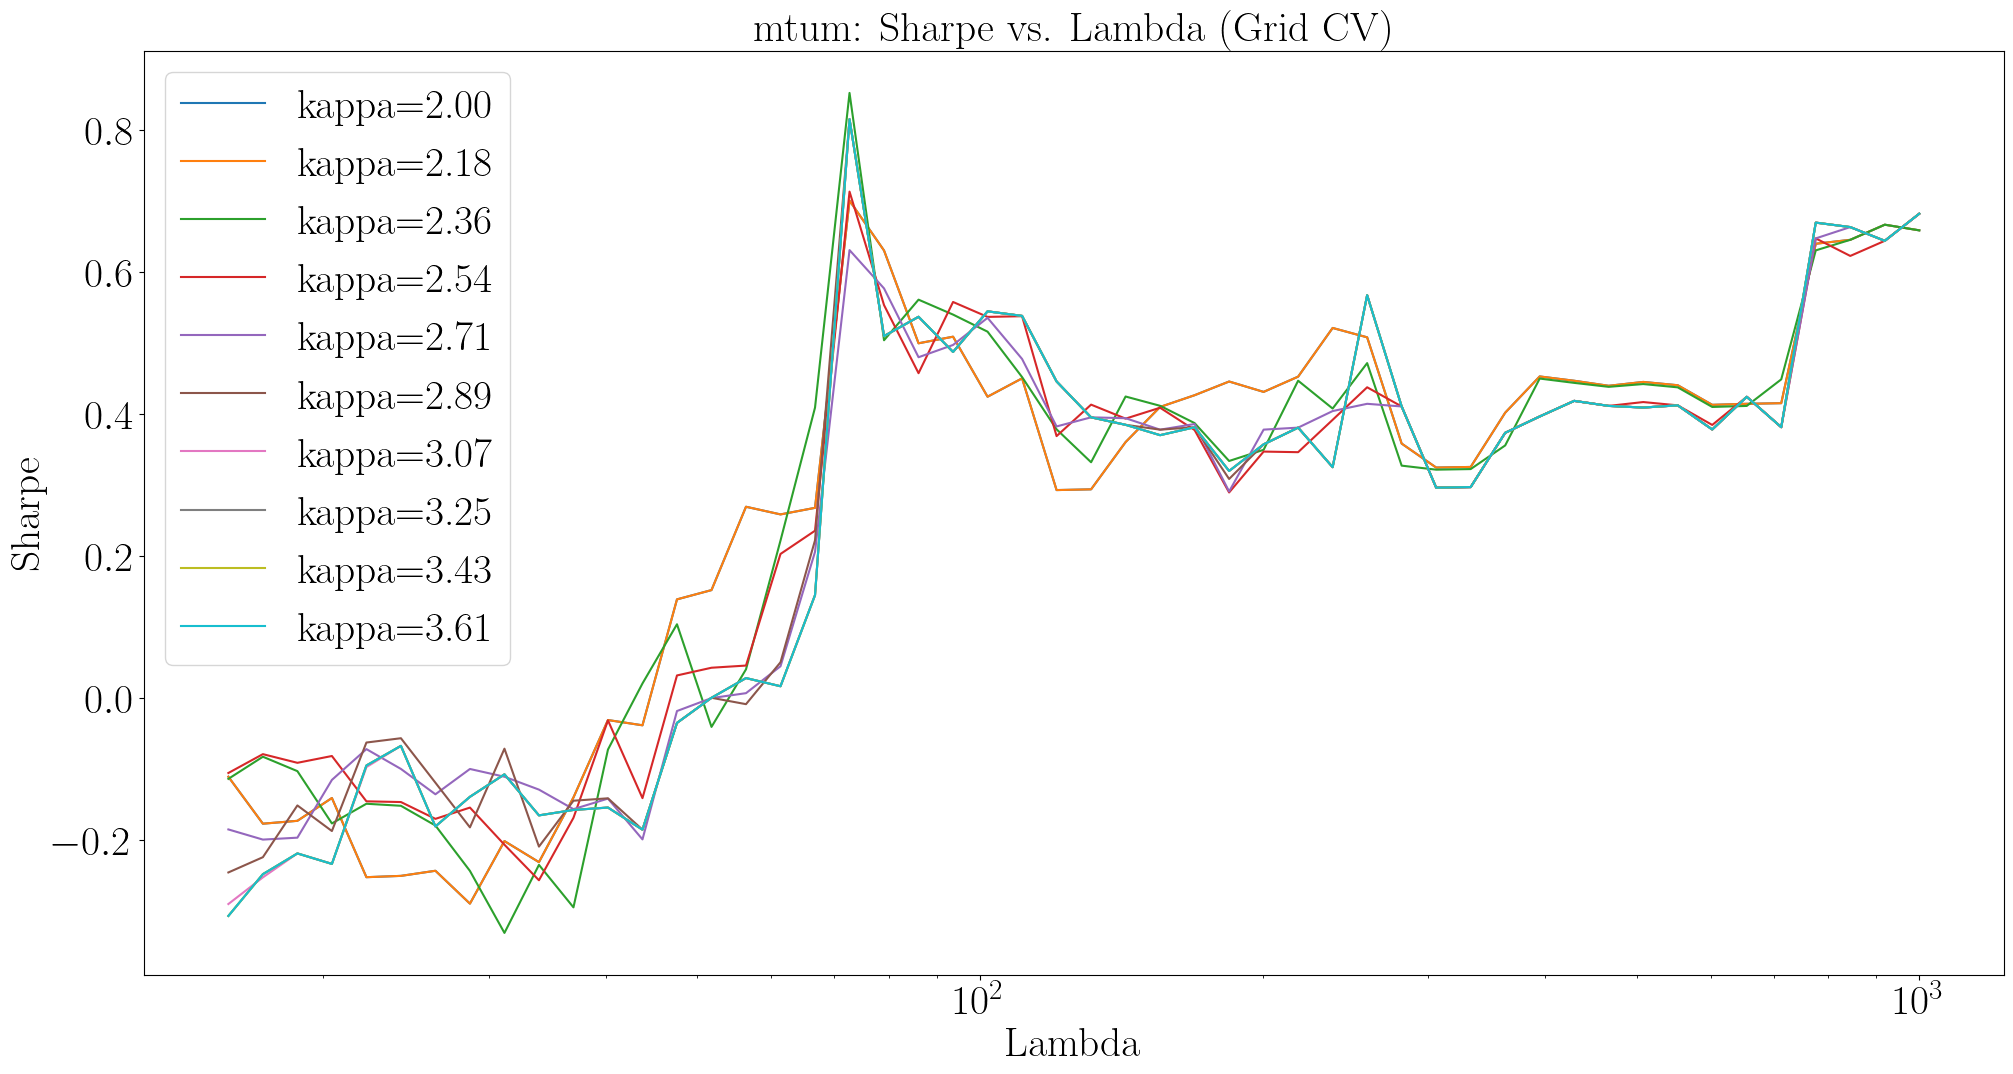

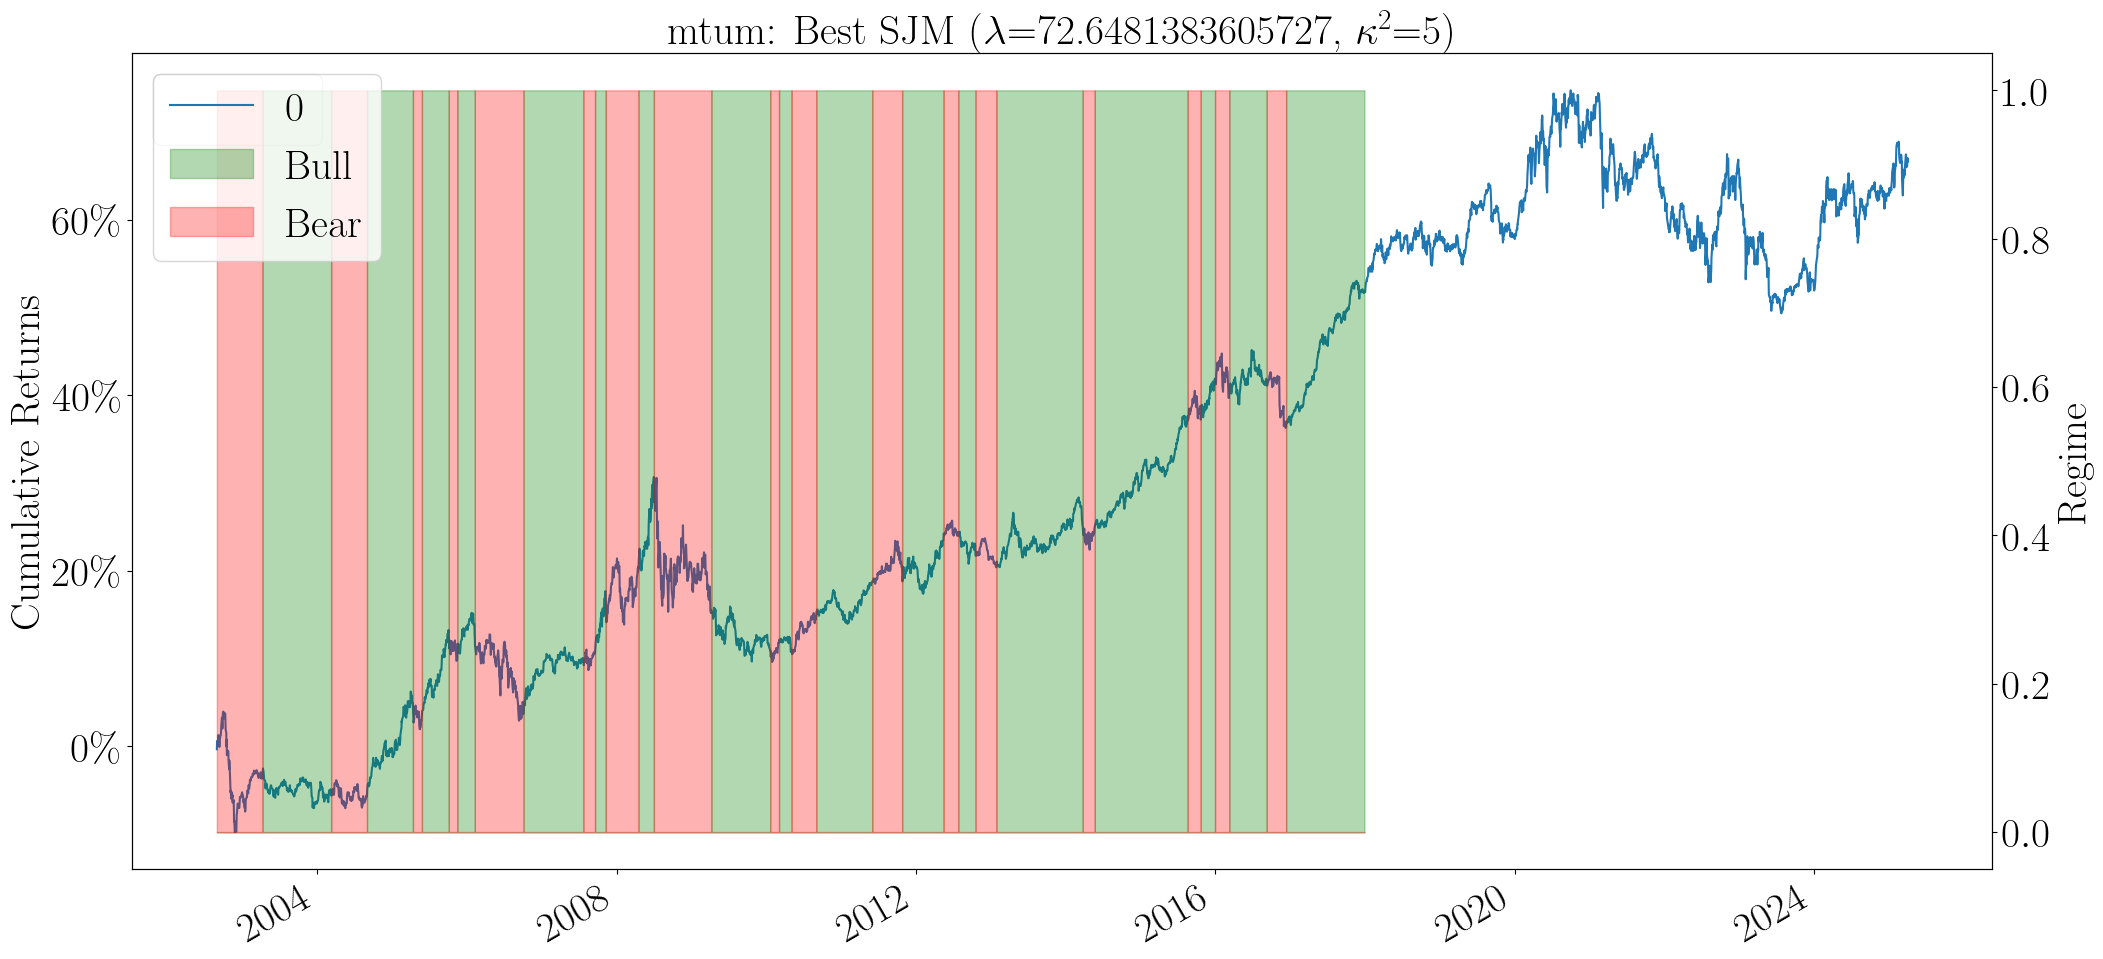


Running SJM cross-validation for factor = qual
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[qual] Best Jump Penalty (λ): 79.06043210907701
[qual] Best Max Features (κ²): 4
[qual] Sharpe with best hyperparams: 0.4407864398200115


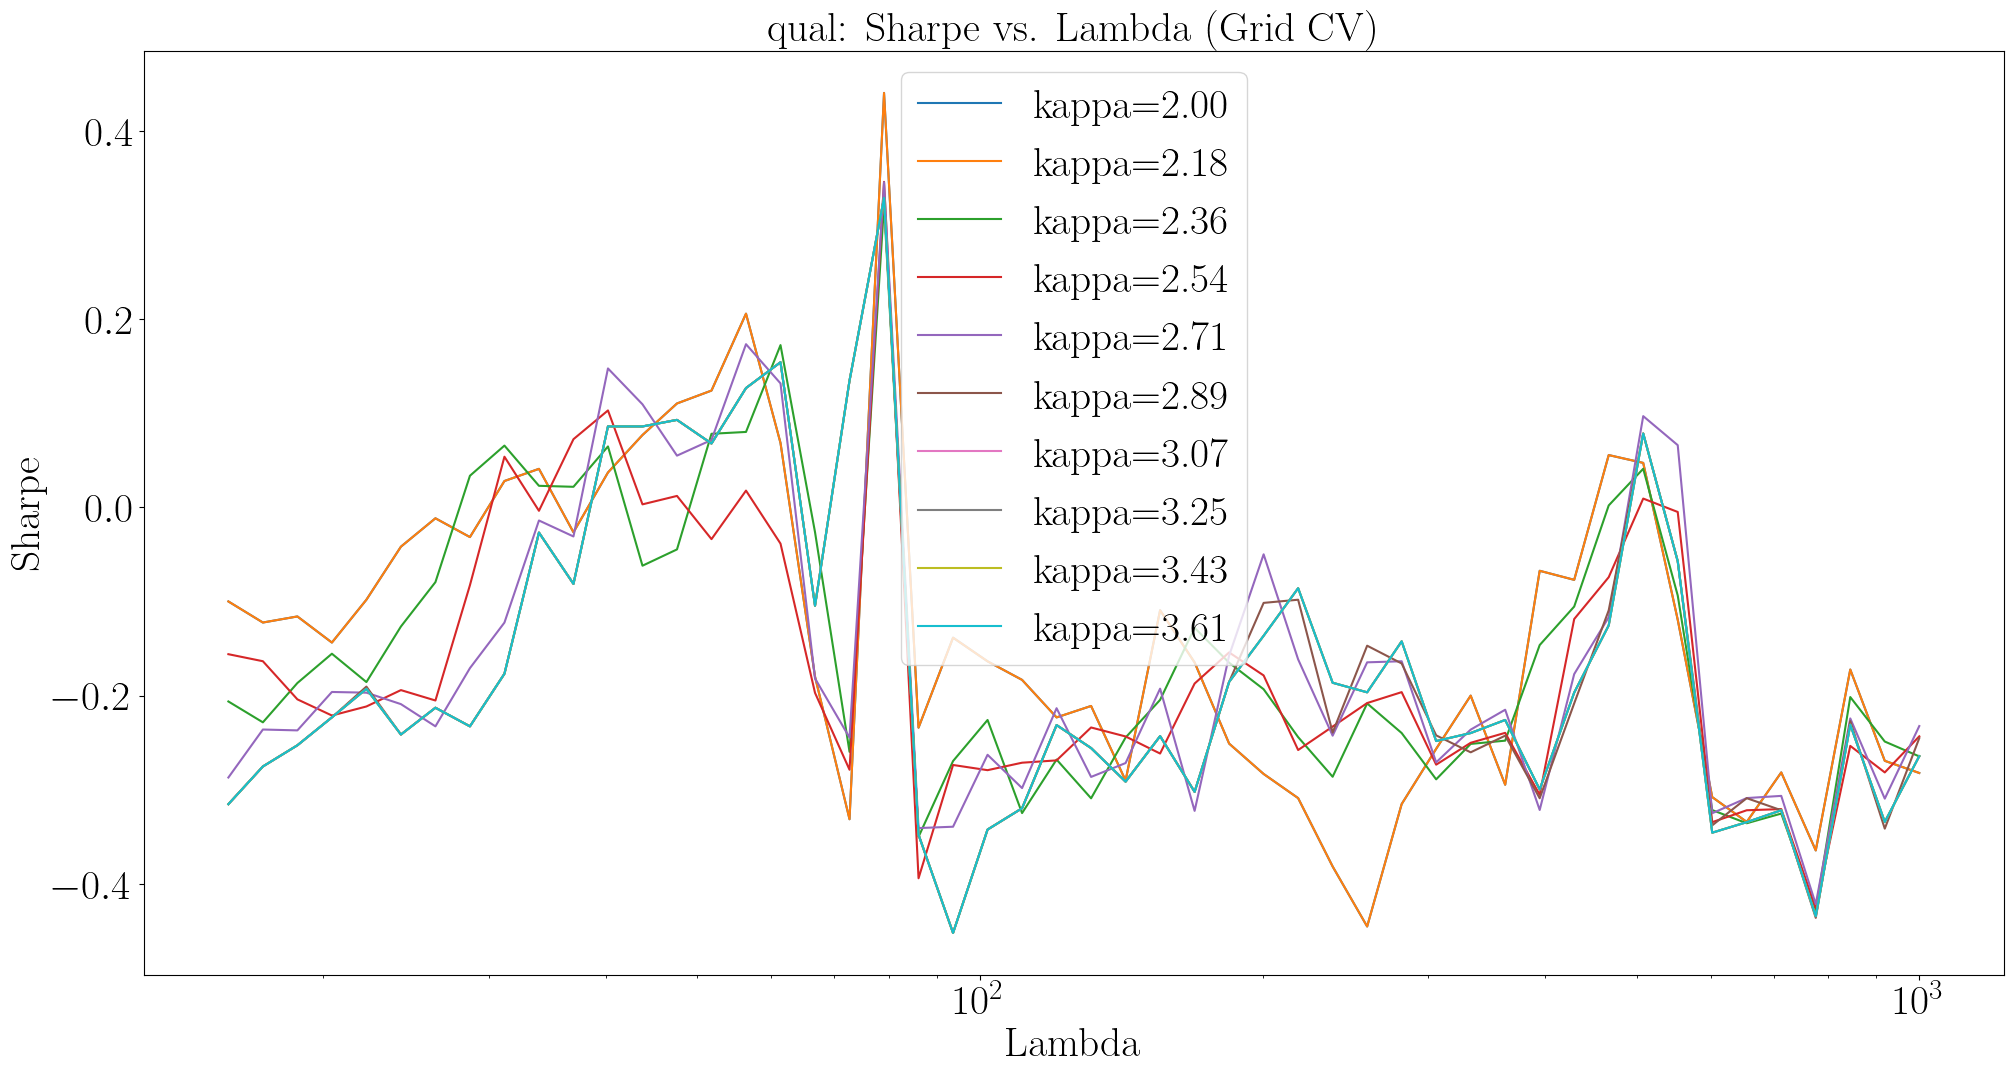

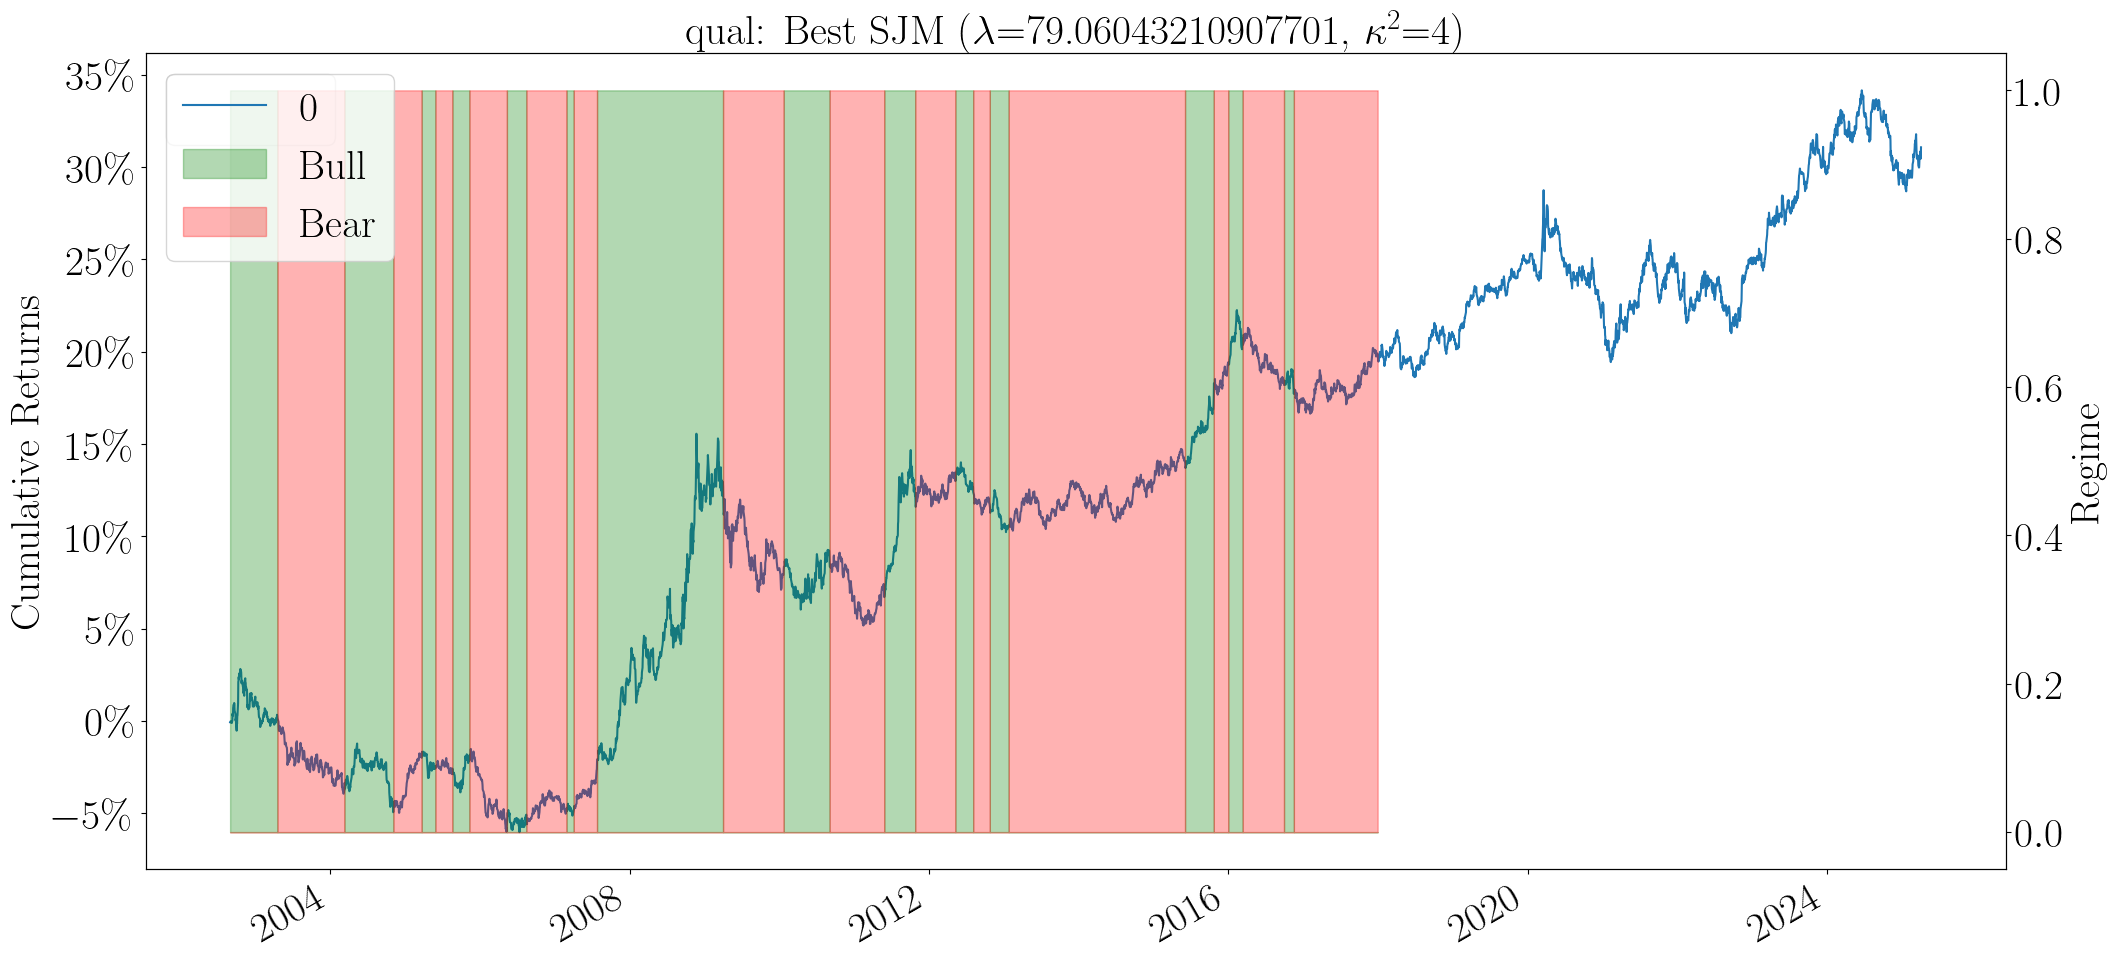


Running SJM cross-validation for factor = size
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[size] Best Jump Penalty (λ): 43.733710577327464
[size] Best Max Features (κ²): 10
[size] Sharpe with best hyperparams: 0.22379891448786776


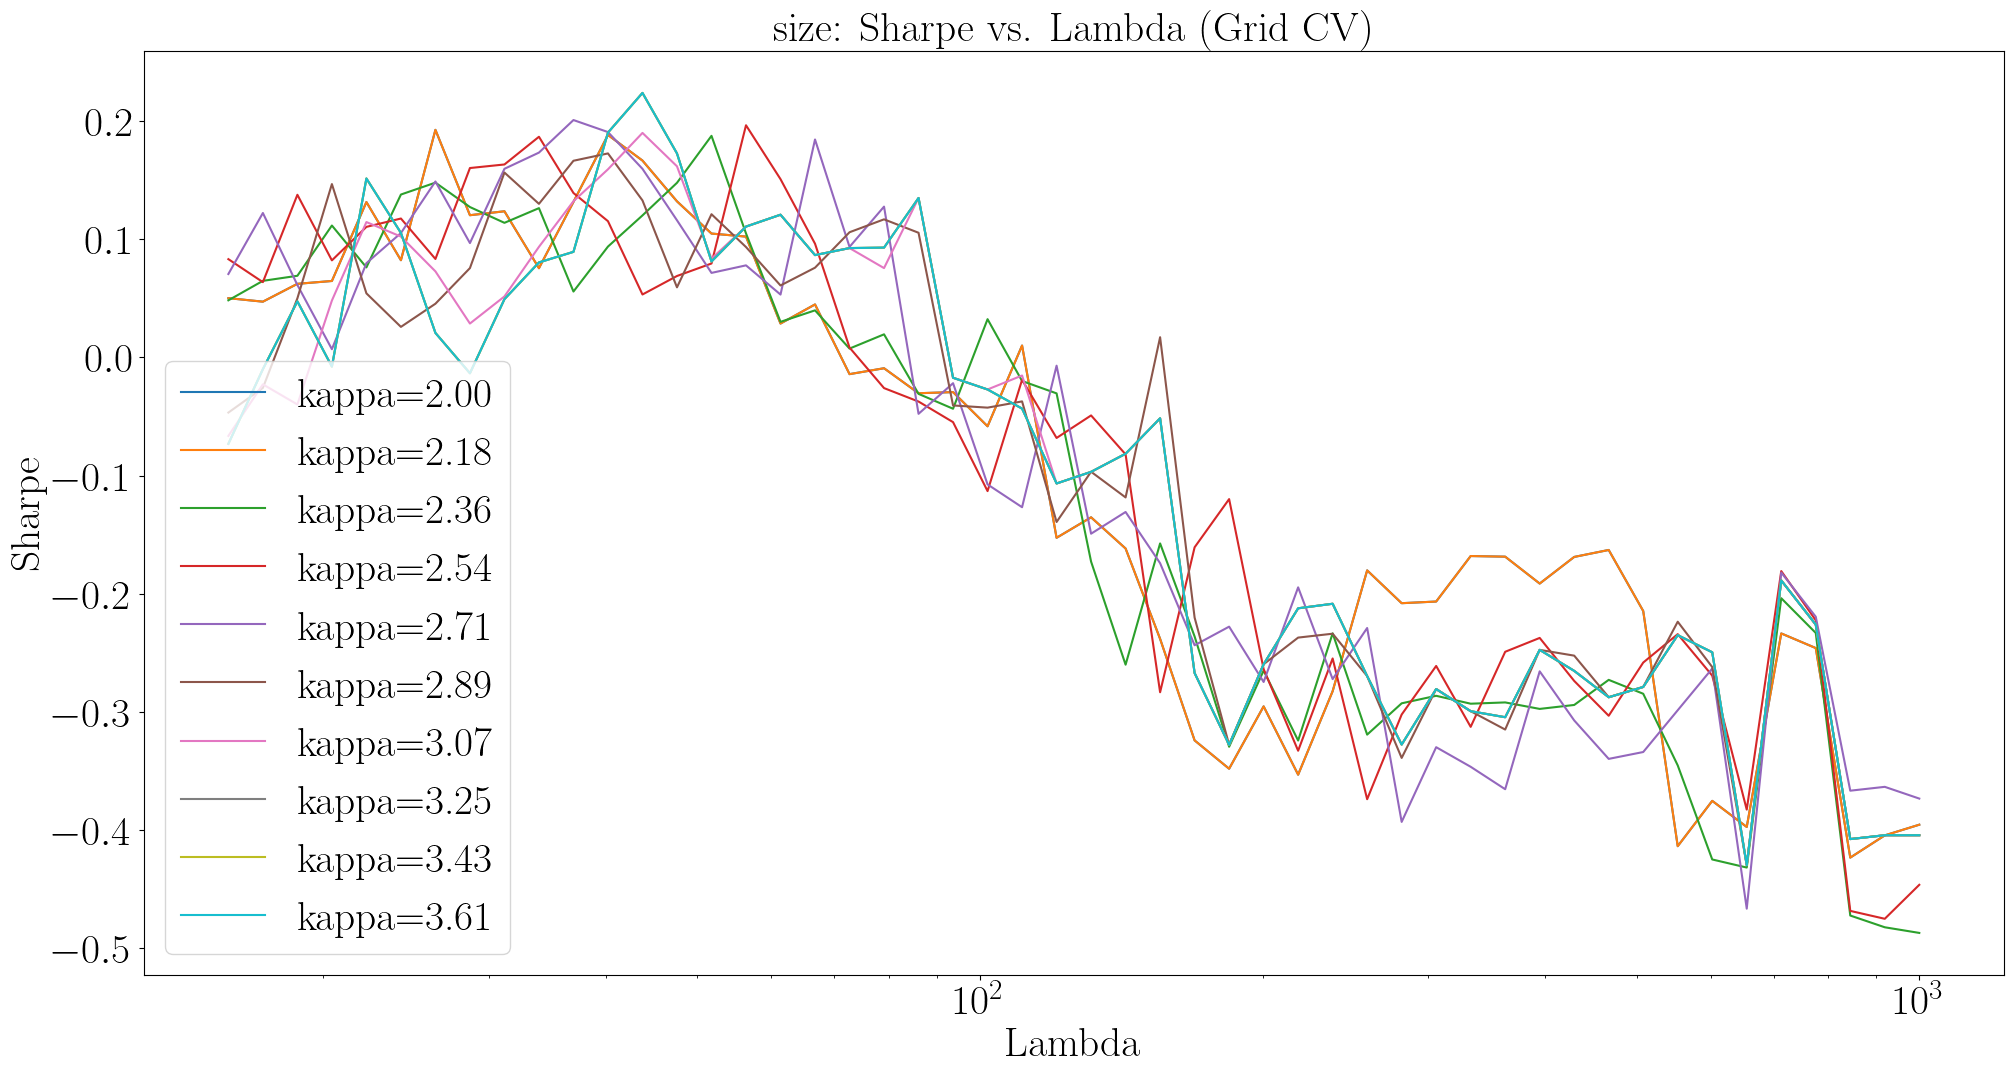

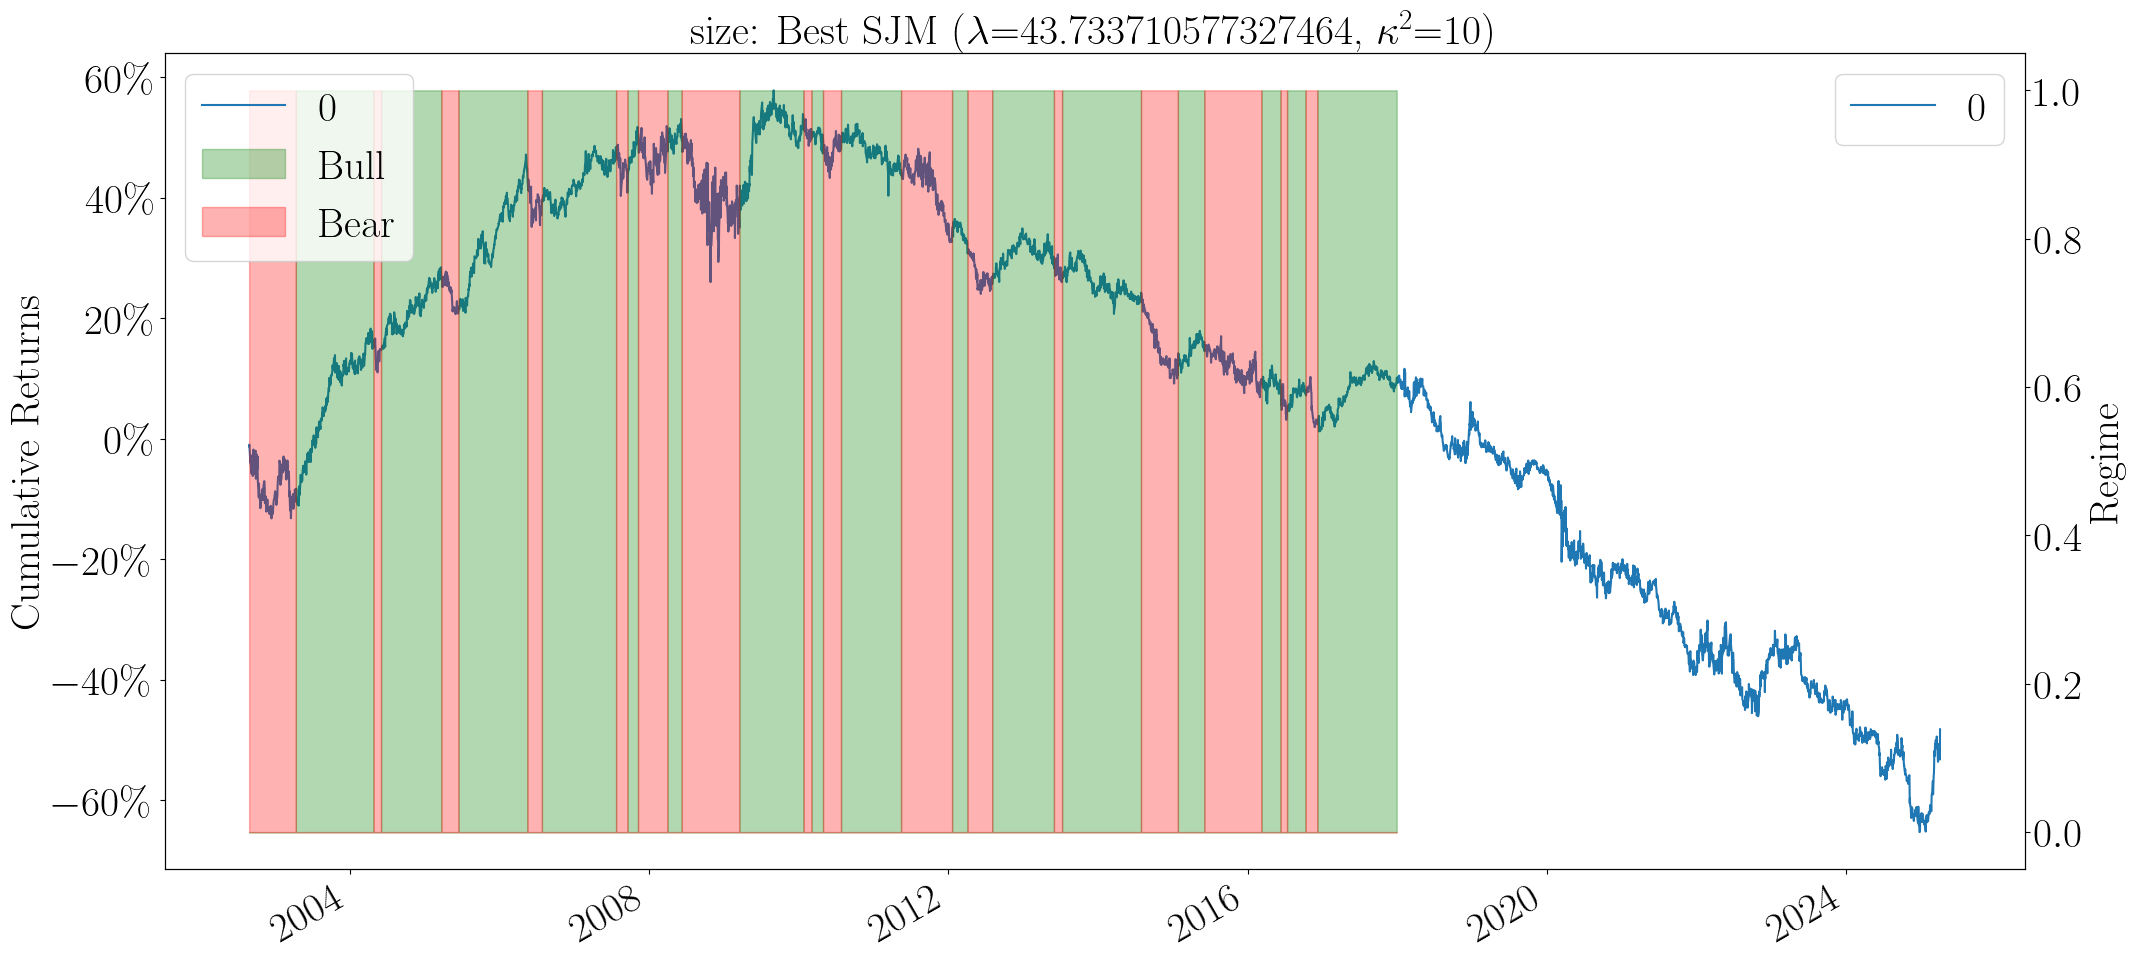


Running SJM cross-validation for factor = usmv
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[usmv] Best Jump Penalty (λ): 362.3962320002086
[usmv] Best Max Features (κ²): 7
[usmv] Sharpe with best hyperparams: 0.03937205366228824


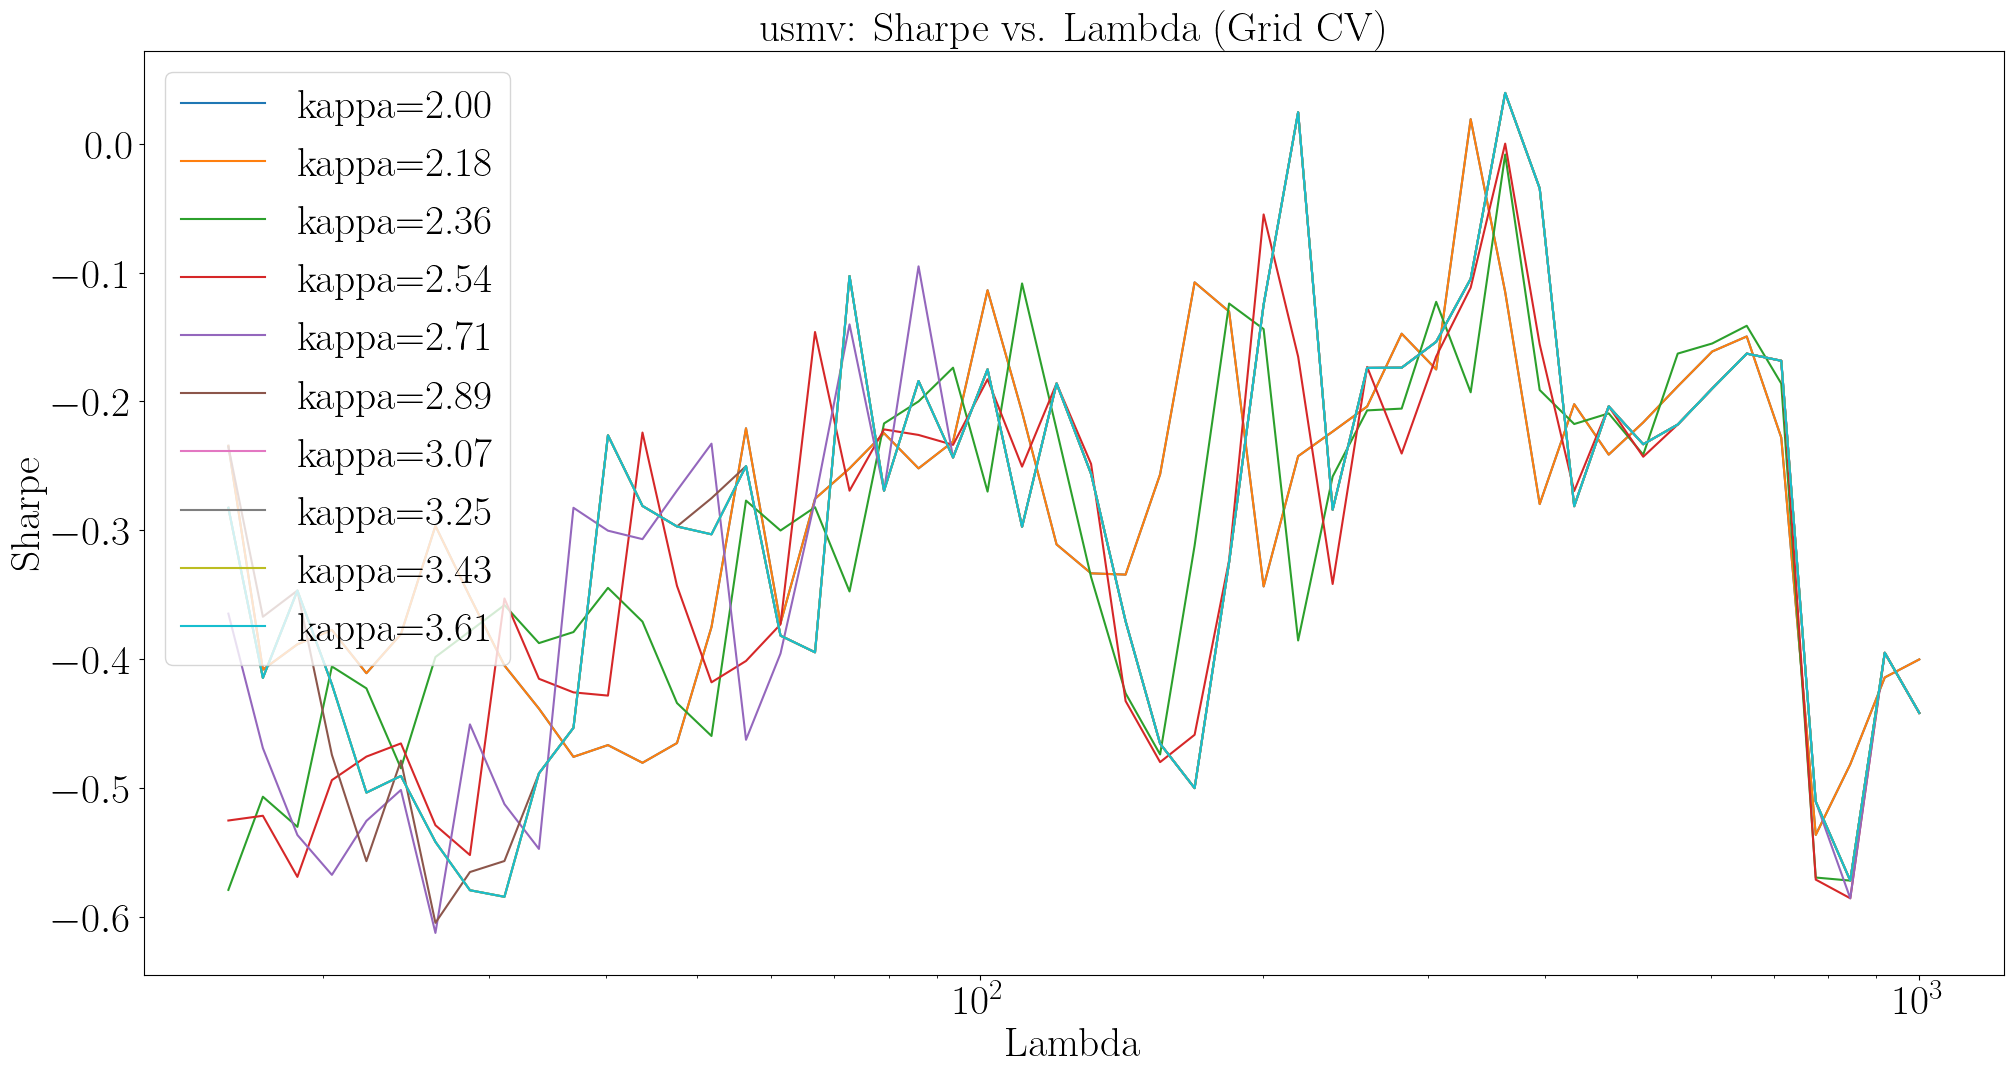

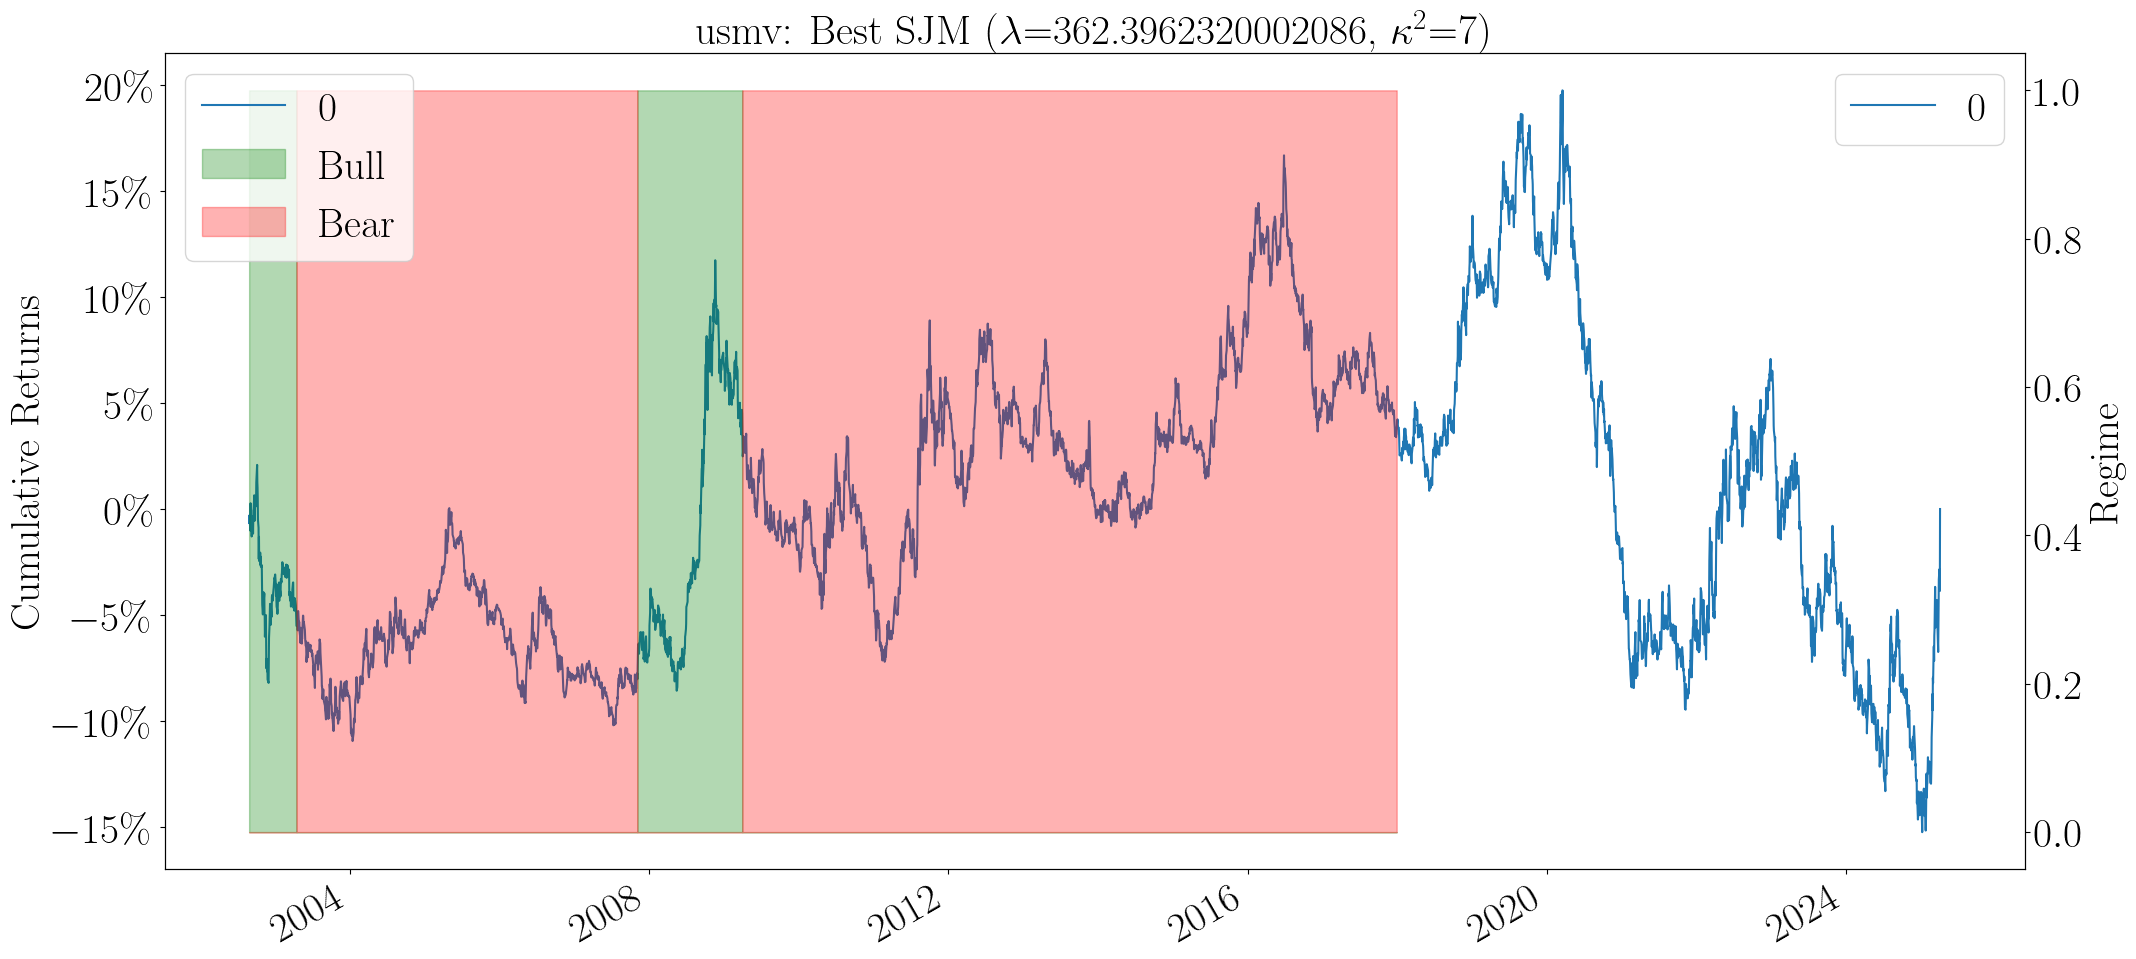


Running SJM cross-validation for factor = vlue
Training starts: 2002-08-29 00:00:00 ends: 2017-12-29 00:00:00
Testing starts: 2018-01-02 00:00:00 ends: 2025-04-03 00:00:00
[vlue] Best Jump Penalty (λ): 93.63292088239417
[vlue] Best Max Features (κ²): 4
[vlue] Sharpe with best hyperparams: 0.5866666285767713


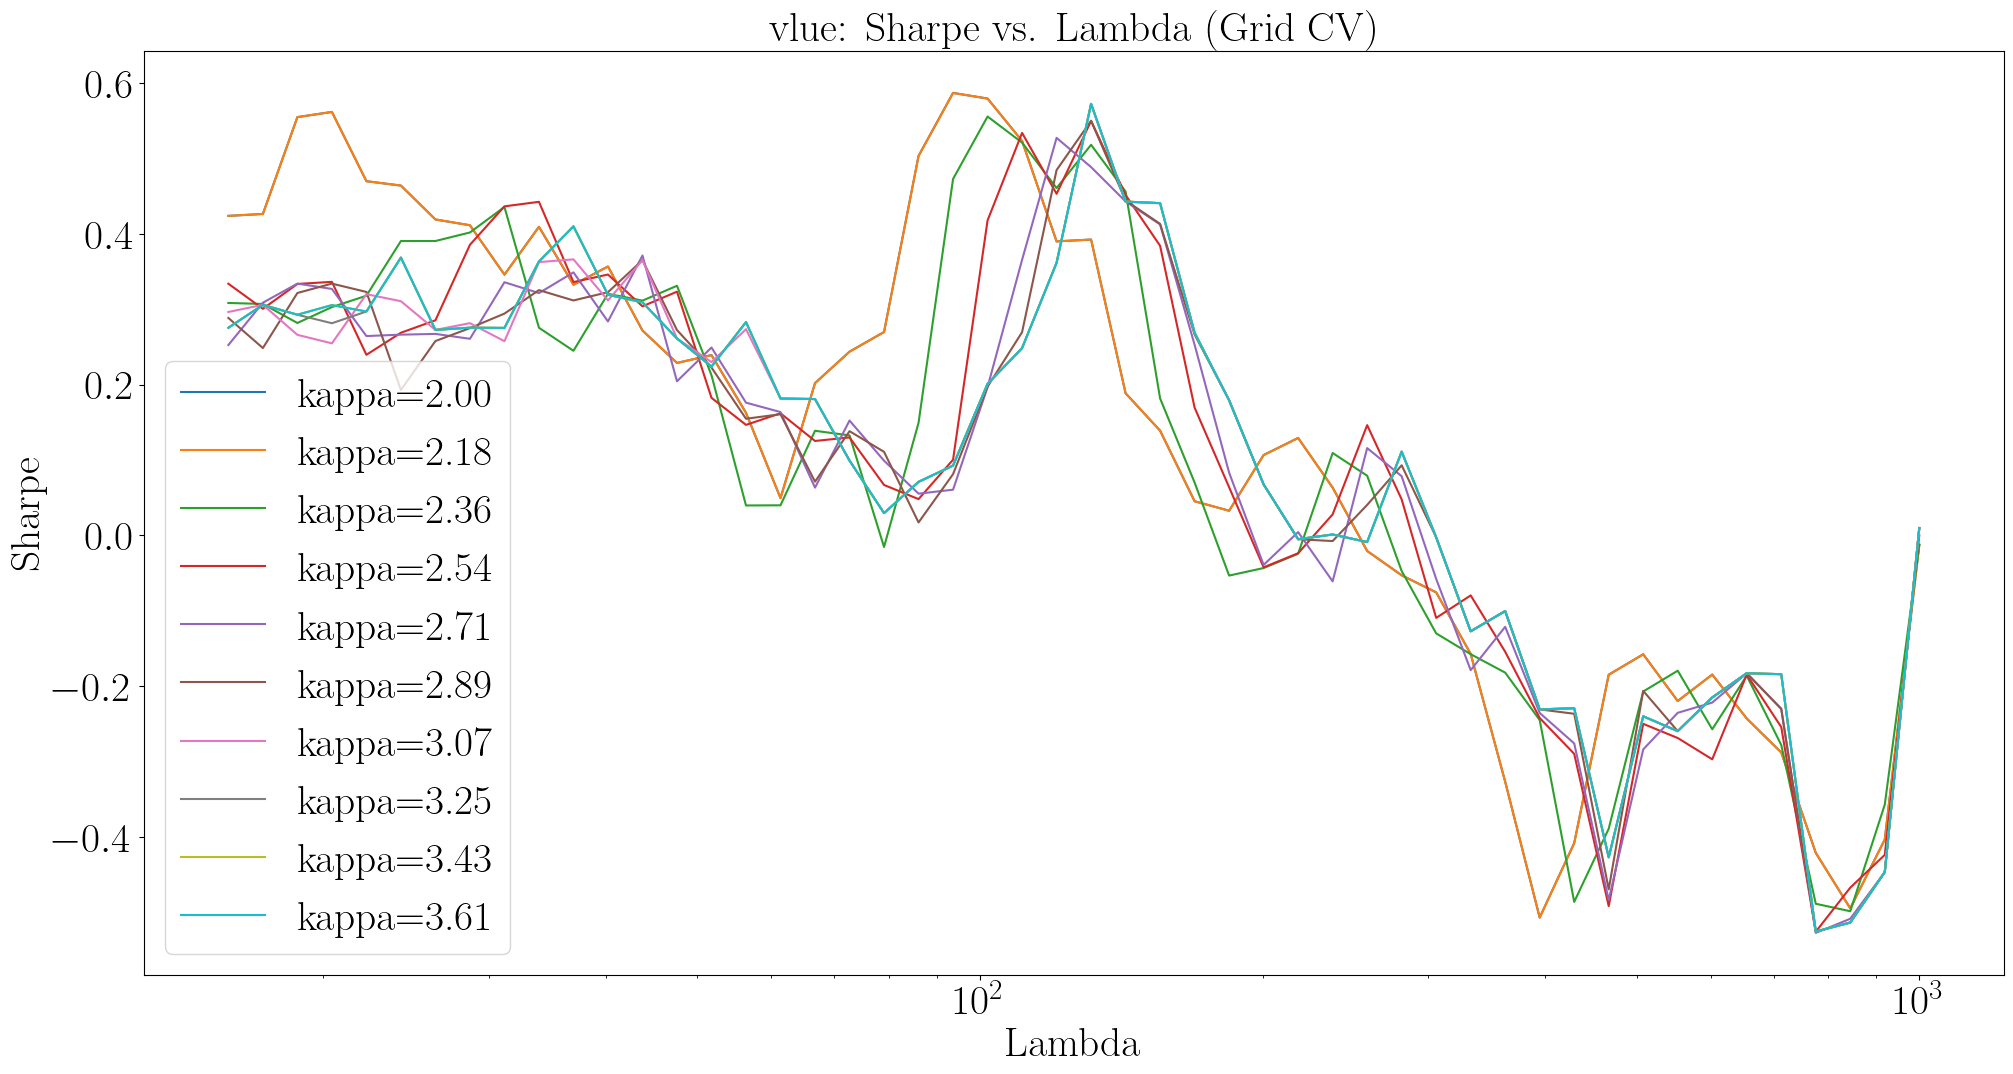

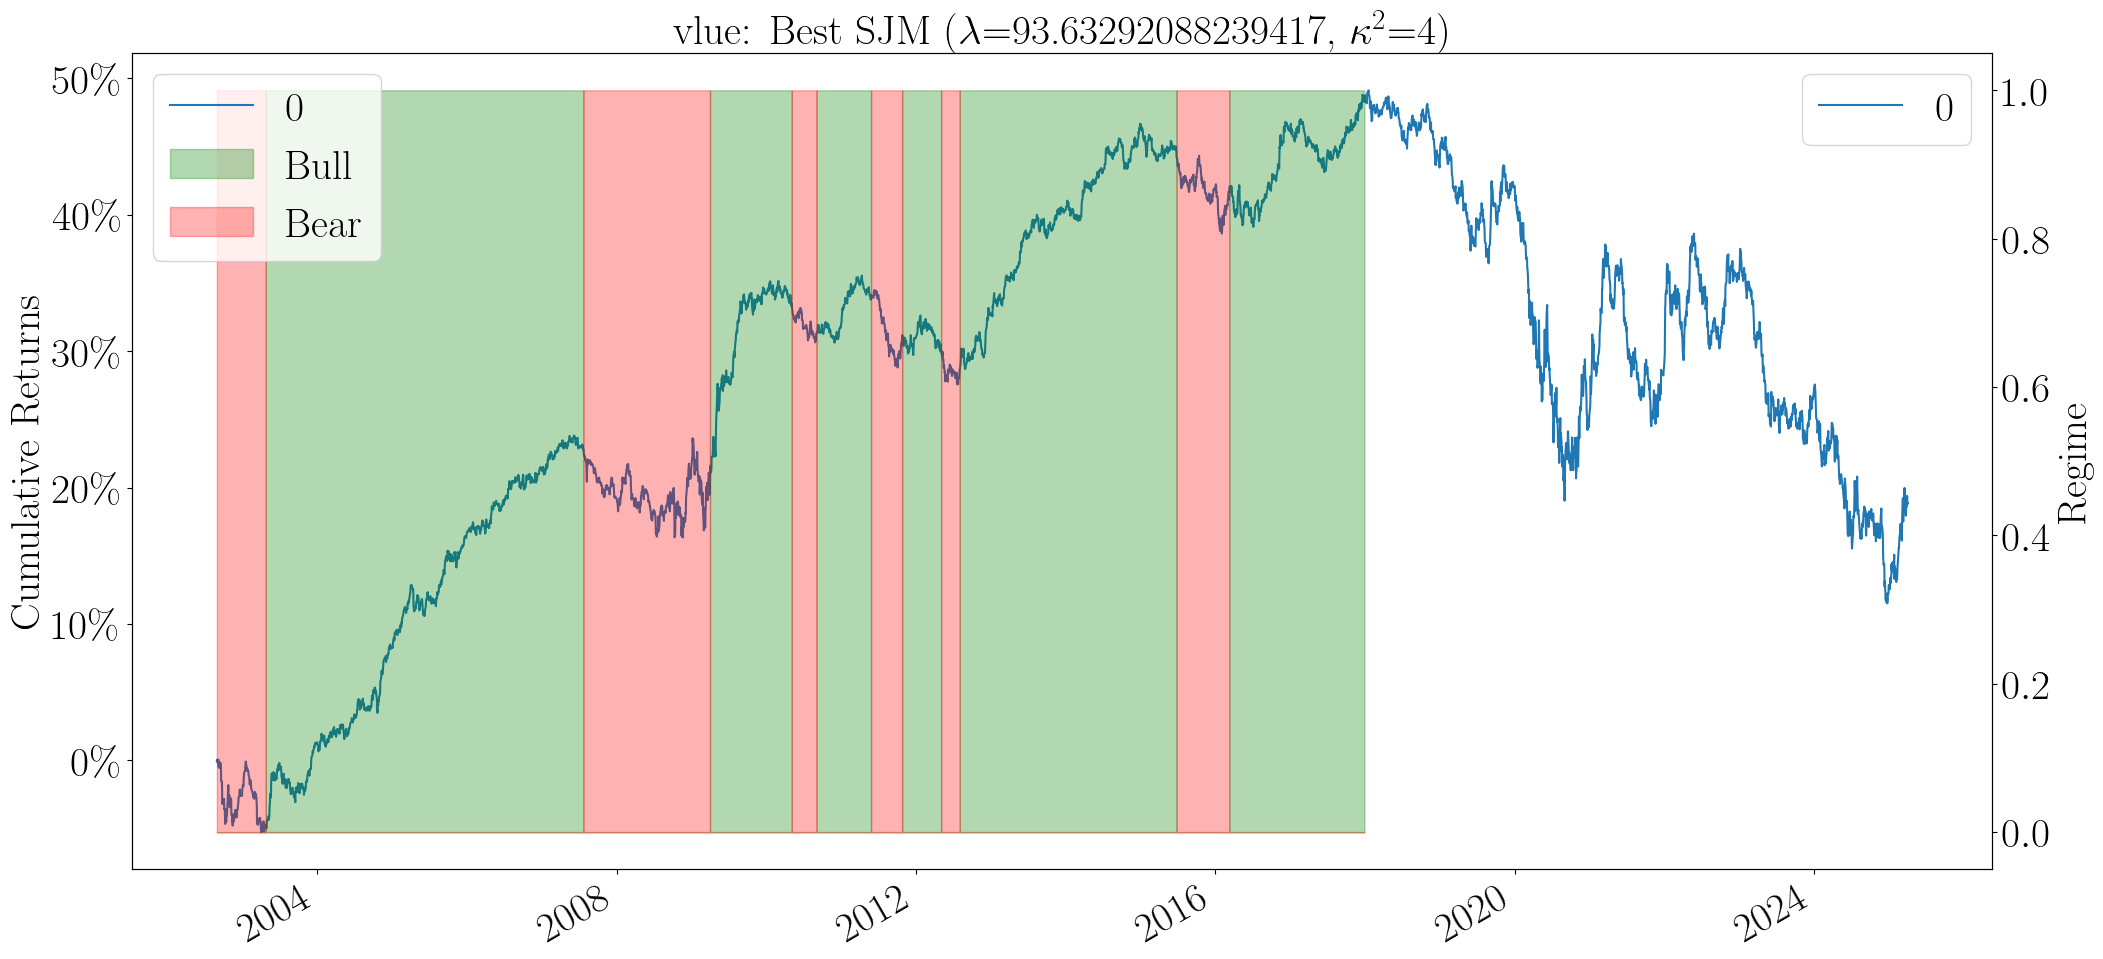


All factors finished.


In [6]:
if __name__ == "__main__":
    directory = r"C:\Users\victo\git_new\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "1estimation_index_returns.csv")
    market_file = os.path.join(directory, "1macro_data.csv")

    # We'll run for these factors:
    all_factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]

    # Dictionary to store best hyperparameters for each factor
    best_hyperparams = {}

    for factor_name in all_factors:
        print("\n==============================================================")
        print(f"Running SJM cross-validation for factor = {factor_name}")
        print("==============================================================")

        # 1) Load data
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=factor_name
        ).load(start_date="2002-04-28", end_date="2025-04-09")

        # Ensure alignment
        common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
        data.X = data.X.loc[common_index]
        data.ret_ser = data.ret_ser.loc[common_index]
        data.market_ser = data.market_ser.loc[common_index]

        # Drop zero-return dates
        zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index
        data.X = data.X.drop(zero_return_dates, errors='ignore')
        data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
        data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')

        # 2) Train/test split
        train_start, test_start = "2002-05-31", "2018-01-01"
        X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
        X_test  = filter_date_range(data.X, start_date=test_start)

        # For reference
        tr_start_idx, tr_end_idx = X_train.index[[0, -1]]
        print("Training starts:", tr_start_idx, "ends:", tr_end_idx)
        if len(X_test) > 0:
            te_start_idx, te_end_idx = X_test.index[[0, -1]]
            print("Testing starts:", te_start_idx, "ends:", te_end_idx)
        else:
            print("No test data after:", test_start)

        # 3) Preprocessing for final model
        clipper = DataClipperStd(mul=3.)
        scalar_pd = StandardScalerPD()
        X_train_processed = scalar_pd.fit_transform(clipper.fit_transform(X_train))
        if len(X_test) > 0:
            X_test_processed  = scalar_pd.transform(clipper.transform(X_test))
        else:
            X_test_processed = None

        # 4) Define hyperparameter grids
        lambda_values = np.logspace(1.2, 3, 50)
        kappa_values  = np.linspace(2, np.sqrt(X_train.shape[1]), 10)

        # 5) Parallel cross-validation
        from joblib import Parallel, delayed
        market_ser = data.market_ser
        results = Parallel(n_jobs=4)(
            delayed(rolling_time_series_cv_sjm_long_short)(
                lam, kappa, 
                X_train,
                factor_returns=data.ret_ser,
                market_returns=market_ser
            )
            for lam in lambda_values
            for kappa in kappa_values
        )

        # 6) Identify best param
        results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
        best_index = np.argmax(results)
        best_lambda = lambda_values[best_index // len(kappa_values)]
        best_kappa  = kappa_values[best_index % len(kappa_values)]
        max_feats_best = int(best_kappa**2)
        best_sharpe = results[best_index]

        print(f"[{factor_name}] Best Jump Penalty (λ): {best_lambda}")
        print(f"[{factor_name}] Best Max Features (κ²): {max_feats_best}")
        print(f"[{factor_name}] Sharpe with best hyperparams: {best_sharpe}")

        # Store best hyperparameters for this factor
        best_hyperparams[factor_name] = {
            "best_lambda": best_lambda,
            "best_kappa": best_kappa
        }

        # 7) Plot Sharpe vs. Lambda for each kappa
        plt.figure()
        for i, kp in enumerate(kappa_values):
            plt.plot(lambda_values, results_array[:, i], label=f"kappa={kp:.2f}")
        plt.xscale('log')
        plt.xlabel('Lambda')
        plt.ylabel('Sharpe')
        plt.title(f"{factor_name}: Sharpe vs. Lambda (Grid CV)")
        plt.legend()
        plt.show()

        # 8) Fit final model on entire training set, predict states, plot in-sample regimes
        final_model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats_best,
            jump_penalty=best_lambda,
            cont=False,
            max_iter=30
        )
        final_model.fit(X_train_processed, data.active_ret, sort_by="cumret")
        predicted_states = final_model.predict(X_train_processed)

        ax, ax2 = plot_regimes_and_cumret(predicted_states, data.active_ret)
        ax.set(title=f"{factor_name}: Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
        plt.show()

    print("\nAll factors finished.")



In [2]:
###############################################################################
# 1) HELPER: EWMA Covariance
###############################################################################
def ewm_covariance(returns: pd.DataFrame, halflife=126, min_periods=1) -> pd.DataFrame:
    """
    Compute an exponentially weighted covariance matrix over all data in 'returns'.
    The half-life is 126 days, meaning weights decay by 50% every 126 days.
    We then select the final NxN slice from the multi-index result.
    """
    ewm_cov = returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).cov()
    if len(returns) == 0:
        # Return an empty DataFrame if no data
        return pd.DataFrame()
    last_date = returns.index[-1]
    df_slice = ewm_cov.loc[last_date]  # shape (N, N)
    df_slice.index.name = None
    return df_slice

In [3]:
###############################################################################
# 2) HELPER: Rolling + Expanding Black–Litterman
###############################################################################
def run_bl_portfolio_pyopt_expanding(
    factor_dict,
    returns_df,
    test_index,
    tau=0.05,
    delta=2.5
):
    """
    An expanding-window Black–Litterman procedure:
    - For each date t in test_index, we take all historical data up to t-1 to compute:
       (a) an EWMA covariance (with half-life=126)
       (b) a BL prior using pi="equal"  (i.e. all assets get equal baseline expected return)
       (c) factor-based relative views: factor vs Market => P, Q
    - Then we get posterior (bl_returns, bl_cov).
    - Then run a standard Efficient Frontier (max_sharpe).
    - We store the resulting weights for day t+1 (one-day lag).
    """
    assets = list(returns_df.columns)   # e.g. [factor1, factor2, ..., Market]
    factors = list(factor_dict.keys())  # e.g. [factor1, factor2, ...]
    weights_df = pd.DataFrame(index=test_index, columns=assets, dtype=float)

    test_dates = list(test_index)

    for i, t in enumerate(test_dates):
        # 1) Expand up to day t-1
        window_end_idx = returns_df.index.get_loc(t)
        if window_end_idx == 0:
            # No prior data => skip
            continue
        expanding_slice = returns_df.iloc[:window_end_idx]

        # 2) Compute the EWMA covariance
        cov_matrix = ewm_covariance(expanding_slice, halflife=126, min_periods=60)
        if cov_matrix.empty or cov_matrix.isna().any().any():
            # If invalid, skip
            continue

        # 3) Construct the (P, Q) for factor vs Market
        #    Q is the list of "annual active returns" for each factor's bull/bear regime
        P_matrix = []
        Q_values = []
        for fac in factors:
            # Which regime do we see for factor "fac" at day t?
            st = factor_dict[fac]['states'].loc[t]
            daily_active_ret = factor_dict[fac]['regime_returns'][st]  # daily factor active
            annual_active_ret = daily_active_ret * 252
            Q_values.append(annual_active_ret)

            # row is +1 on factor, -1 on 'Market'
            row = [0]*len(assets)
            row[assets.index(fac)] = 1
            row[assets.index("Market")] = -1
            P_matrix.append(row)

        P = pd.DataFrame(P_matrix, columns=assets)
        Q = pd.Series(Q_values)

        # 4) Build the Black–Litterman model
        #    We'll say pi="equal" so that each asset has the same baseline prior
        #    Then we incorporate the relative views in (P, Q).
        #    tau=0.05 is a typical default.
        try:
            bl = BlackLittermanModel(
                cov_matrix=cov_matrix,
                pi="equal",
                P=P,
                Q=Q,
                tau=tau,
                delta=delta,
                # no "omega" => default is Proportional to var of view portfolio
            )
        except Exception as e:
            print(f"BL Model error on day {t}: {e}")
            continue

        # 5) Retrieve posterior returns & covariance
        mu_bl = bl.bl_returns()
        cov_bl = bl.bl_cov()  # posterior covariance

        # 6) Mean-variance optimization
        ef = EfficientFrontier(mu_bl, cov_bl, weight_bounds=(-0, 1))
        try:
            ef.max_sharpe()  # or ef.min_volatility() etc.
        except Exception as e:
            print(f"Optimization error on day {t}: {e}")
            continue

        # 7) Store weights for day t+1 (one-day lag)
        w_series = pd.Series(ef.clean_weights(), name=t)
        if i < len(test_dates) - 1:
            rebalance_day = test_dates[i+1]
            weights_df.loc[rebalance_day] = w_series
        else:
            weights_df.loc[t] = w_series

    return weights_df


In [ ]:
# ---------------------------------------------------------------------
# Sharpe Ratio
# ---------------------------------------------------------------------
def annualized_sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

In [ ]:
# # manual build of best_hyperparams dict for BL model if we don't want to run the SJM CV again
# best_hyperparams = {
#     "IWF": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.0
#     },
#     "MTUM": {
#         "best_lambda": 239.5026619987486,
#         "best_kappa": 2.0
#     },
#     "QUAL": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.44948974278
#     },
#     "SIZE": {
#         "best_lambda": 49.72235891449993,
#         "best_kappa": 3.46410161514
#     },
#     "USMV": {
#         "best_lambda": 751.3842180360134,
#         "best_kappa": 2.44948974278
#     },
#     "VLUE": {
#         "best_lambda": 57.36152510448679,
#         "best_kappa": 2
#     },
# }


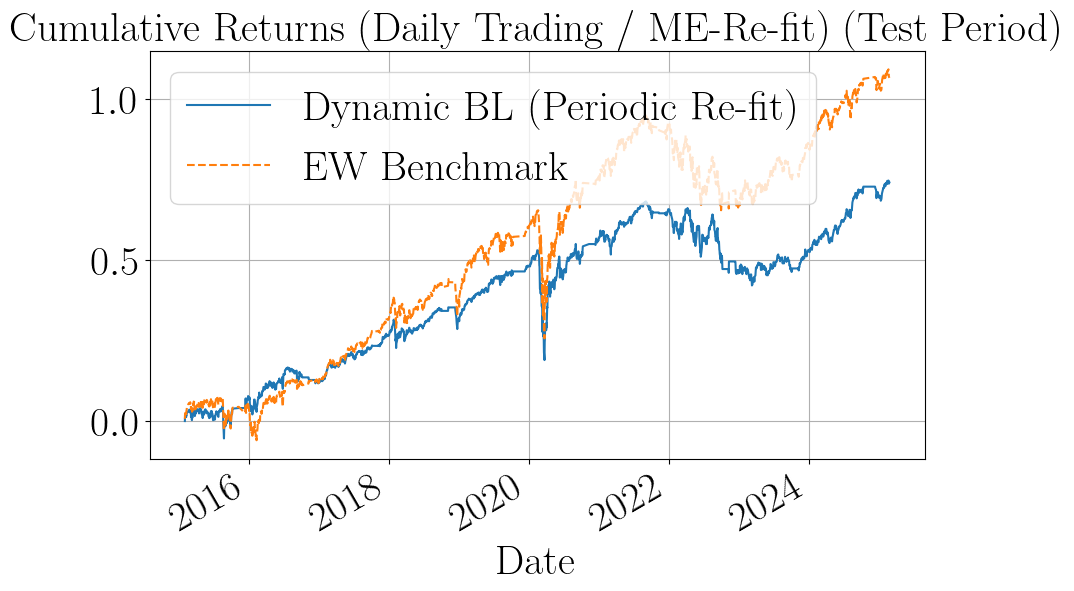

EW Portfolio Sharpe: 0.7065390451940337
Dynamic BL Portfolio Sharpe: 0.6813641066381825
Dynamic BL Total Return: 0.7411913257486049


In [ ]:
if __name__ == "__main__":

    ############################################################################
    # 0) Set parameters
    ############################################################################
    # We define how often to re-fit:
    REFIT_FREQ = "ME"  # change to "QE" or "YE" as desired.

    # Paths & Tickers
    directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "factor_data.csv")
    market_file = os.path.join(directory, "market_data.csv")
    factors = ["IWF", "MTUM", "QUAL", "SIZE", "USMV", "VLUE"]

    # Date boundaries
    train_start = "2002-05-31"
    test_start  = "2018-01-01"

    ############################################################################
    # 1) Load full data for all factors & market
    ############################################################################
    # We'll store each factor's entire X and returns in a dict for easy access
    factor_data_dict = {}
    factor_returns_list = []
    for fac in factors:
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=fac
        ).load()
        common_idx = (
            data.X.index
            .intersection(data.ret_ser.index)
            .intersection(data.market_ser.index)
        )

        # Full factor data
        X_full       = data.X.loc[common_idx]
        fac_ret_full = data.ret_ser.loc[common_idx]
        mkt_ret_full = data.market_ser.loc[common_idx]
        active_ret   = fac_ret_full - mkt_ret_full

        factor_data_dict[fac] = {
            "X": X_full,
            "fac_ret": fac_ret_full,
            "mkt_ret": mkt_ret_full,
            "active_ret": active_ret
        }
        factor_returns_list.append(fac_ret_full)

    # We'll store the last loaded "mkt_ret_full" as "all_market_ret"
    # (or re-load from data, whichever you prefer)
    all_market_ret = mkt_ret_full

    # Combine factor returns + market into a single DF (same as your original code)
    full_factors_df = pd.concat(factor_returns_list, axis=1).dropna()  # T x 6
    full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
    full_df.columns = factors + ["Market"]

    # Our "test_index" is from test_start onward
    test_slice = filter_date_range(full_df, start_date=test_start)
    test_index = test_slice.index.sort_values()

    # Identify "refit boundaries" (month-ends, quarter-ends, or year-ends) 
    # from test_start onward.
    refit_boundaries = (
        test_index.to_series()
        .resample(REFIT_FREQ)
        .last()
        .dropna()
    )

    # If the very first boundary doesn't match your first test date, you might force-add it:
    # e.g. if test_index[0] not in refit_boundaries, 
    #      do refit_boundaries = sorted(set([test_index[0]]) | set(refit_boundaries))

    ############################################################################
    # 2) Loop over re-fit intervals
    ############################################################################
    # We will accumulate daily states for each factor, daily weights, daily returns
    all_daily_states  = {fac: pd.Series(dtype=float) for fac in factors}
    all_daily_weights = []
    all_daily_rets    = []

    for i in range(len(refit_boundaries) - 1):
        refit_date = refit_boundaries.iloc[i]
        next_refit_date = refit_boundaries.iloc[i + 1]

        # Define the "training set" end date = refit_date
        # We train on everything from [train_start : refit_date]
        # Then do daily inference/trading from (refit_date, next_refit_date]
        train_end = refit_date
        test_mask = (test_index > refit_date) & (test_index <= next_refit_date)
        test_dates_chunk = test_index[test_mask]
        if len(test_dates_chunk) == 0:
            # No trading days in this chunk? Move on
            continue

        # We'll build a factor_dict that includes the newly fitted model + daily states
        # for each factor, just for this chunk.
        factor_dict_chunk = {}

        for fac in factors:
            fac_info = factor_data_dict[fac]
            X        = fac_info["X"]
            ret_full = fac_info["fac_ret"]
            mkt_full = fac_info["mkt_ret"]
            active   = fac_info["active_ret"]

            # -----------------------------------------------------------------
            # 2A) Build training data up to train_end
            # -----------------------------------------------------------------
            X_train = filter_date_range(X, start_date=train_start, end_date=train_end)
            y_train = filter_date_range(active, start_date=train_start, end_date=train_end)

            # Scale + Clip the training set
            clipper = DataClipperStd(mul=3.0)
            scaler_pd = StandardScalerPD()
            X_train_clip = clipper.fit_transform(X_train)
            X_train_proc = scaler_pd.fit_transform(X_train_clip)

            # Fit SJM with best hyperparams
            lam = best_hyperparams[fac]["best_lambda"]
            kp  = best_hyperparams[fac]["best_kappa"]
            max_feats = int(kp**2)

            sjm = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=lam)
            sjm.fit(X_train_proc, ret_ser=y_train)

            # -----------------------------------------------------------------
            # 2B) Daily "online" inference from refit_date+1 to next_refit_date
            # -----------------------------------------------------------------
            # For each day in test_dates_chunk, do the day-by-day scaling and inference
            X_test_proc_list = []
            for day in test_dates_chunk:
                # Build an incremental history from [train_start : day]
                # (this ensures the day-by-day scaling uses up to 'day-1' data)
                X_hist = X.loc[:day]

                # Clip & scale X_hist
                ctemp = DataClipperStd(mul=3.0)
                X_hist_clip = ctemp.fit_transform(X_hist)

                stemp = StandardScaler()
                X_hist_scal = stemp.fit_transform(X_hist_clip)

                # Now transform just the row for 'day'
                if day in X.index:
                    X_day = X.loc[[day]]
                    X_day_clip = ctemp.transform(X_day)
                    X_day_scal = stemp.transform(X_day_clip)
                    X_test_proc_list.append(
                        pd.Series(X_day_scal.flatten(), index=X_day.columns, name=day)
                    )
                else:
                    # If for some reason day not in X, skip
                    pass

            X_test_proc_df = pd.DataFrame(X_test_proc_list).sort_index()

            # Predict states
            if not X_test_proc_df.empty:
                states_chunk = sjm.predict_online(X_test_proc_df)
                states_series = pd.Series(states_chunk, index=X_test_proc_df.index)
            else:
                states_series = pd.Series(dtype=float)

            # Accumulate to the "global" daily states for that factor
            #all_daily_states[fac] = pd.concat([all_daily_states[fac], states_series]).sort_index()

            # Replaced the line above to avoid warning about empty series. revert to old if error: (#all_daily_states[fac] = pd.concat([all_daily_states[fac], states_series]).sort_index()) 
            series_to_concat = [s for s in [all_daily_states[fac], states_series] if not s.empty]
            if series_to_concat:
                all_daily_states[fac] = pd.concat(series_to_concat).sort_index()
            else:
                all_daily_states[fac] = pd.Series(dtype=float)

            # We'll also store the factor info needed for BL
            # (regime returns, the full factor ret, the daily states, etc.)
            factor_dict_chunk[fac] = {
                "ret": ret_full,  # full factor ret
                "states": states_series,
                "regime_returns": {
                    0: sjm.ret_[0],
                    1: sjm.ret_[1],
                },
            }

        # ---------------------------------------------------------------------
        # 2C) Run BL daily (or however your function does it) over test_dates_chunk
        #     using the factor_dict we just built (which has states for each day).
        # ---------------------------------------------------------------------
        # The "run_bl_portfolio_pyopt_expanding" function in your original code
        # expects:
        #   - factor_dict
        #   - returns_df (the big full_df)
        #   - test_index (the daily dates we want to rebalance)
        #   - tau, delta
        #
        # This will produce daily weights for test_dates_chunk.
        # If your function uses an expanding window for covariance,
        # it can use the entire 'returns_df' but only produce weights on 'test_dates_chunk'.
        weights_chunk = run_bl_portfolio_pyopt_expanding(
            factor_dict=factor_dict_chunk,
            returns_df=full_df,
            test_index=test_dates_chunk,
            tau=0.05,
            delta=2.5
        )

        # ---------------------------------------------------------------------
        # 2D) Compute daily returns for test_dates_chunk
        # ---------------------------------------------------------------------
        daily_factor_rets = full_df.loc[test_dates_chunk, factors]  # shape: (days x factors)
        portfolio_rets = (weights_chunk * daily_factor_rets).sum(axis=1)

        # Store
        all_daily_weights.append(weights_chunk)
        all_daily_rets.append(portfolio_rets)

    # -------------------------------------------------------------------------
    # 3) Combine all daily outputs
    # -------------------------------------------------------------------------
    if len(all_daily_rets) == 0:
        raise ValueError("No daily returns computed. Check your date ranges or data.")

    all_portfolio_rets = pd.concat(all_daily_rets).sort_index()
    all_weights_df     = pd.concat(all_daily_weights).sort_index()
    cumrets            = all_portfolio_rets.cumsum()

    # -------------------------------------------------------------------------
    # 4) Compare to an equal-weight benchmark over the same test period
    # -------------------------------------------------------------------------
    overlap_idx = all_portfolio_rets.index.intersection(full_df.index)
    test_returns_df = full_df.loc[overlap_idx, :]
    ew_bench_rets = test_returns_df.mean(axis=1)  # daily average of 7 columns (6 factors + Market)
    ew_bench_cum  = ew_bench_rets.cumsum()

    # -------------------------------------------------------------------------
    # 5) Plot and stats
    # -------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    cumrets.plot(label="Dynamic BL (Periodic Re-fit)")
    ew_bench_cum.plot(label="EW Benchmark", linestyle="--")
    plt.title(f"Cumulative Returns (Daily Trading / {REFIT_FREQ}-Re-fit) (Test Period)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("EW Portfolio Sharpe:", annualized_sharpe(ew_bench_rets))
    print("Dynamic BL Portfolio Sharpe:", annualized_sharpe(all_portfolio_rets))
    print("Dynamic BL Total Return:", cumrets.iloc[-1])


In [6]:
# Create a DataFrame with both sets of daily returns
df_for_plot = pd.DataFrame({
    "Dynamic BL": all_portfolio_rets,
    "EW Benchmark": ew_portfolio_returns
}).dropna(how="all")

# Use the jumpmodels.plot function to plot cumulative returns
ax = plot_cumret(df_for_plot)

# Optionally set a title or other formatting
ax.set_title("Cumulative Returns: BL vs. EW")

plt.show()

NameError: name 'ew_portfolio_returns' is not defined

In [6]:
for factor_name in results_dict.keys():
    # 1) Grab the test states from results_dict
    states_series = results_dict[factor_name]["test_states"]

    active_ret = results_dict[factor_name]["full_active_return"]
    
    # 5) Plot using plot_regimes_and_cumret
    ax, ax2 = plot_regimes_and_cumret(states_series, active_ret)
    ax.set_title(f"{factor_name} - Test Period Regimes")
    plt.show()

NameError: name 'results_dict' is not defined

In [7]:
# Define a short loop to calculate a Quarterly-Rebalanced EW portfolio
quarterly_ends = test_returns_df.index.to_series().resample("QE").last().dropna()
n_assets = test_returns_df.shape[1]

# We'll store the daily returns of this buy-and-hold approach
quarterly_ew_rets = pd.Series(index=test_returns_df.index, dtype=float)

for i in range(len(quarterly_ends) - 1):
    start_q = quarterly_ends.iloc[i]
    end_q   = quarterly_ends.iloc[i + 1]
    # We'll take the slice of daily returns for this quarter (start_q, end_q]
    mask = (test_returns_df.index > start_q) & (test_returns_df.index <= end_q)
    chunk_dates = test_returns_df.index[mask]
    
    # Initialize weights = 1/n at the start of the quarter
    w = np.ones(n_assets) / n_assets
    
    # For each day in this quarter, compute the portfolio return (dot product),
    # store it, then update weights to reflect buy-and-hold drift
    for day in chunk_dates:
        r_i = test_returns_df.loc[day].values  # daily returns for each asset
        r_p = np.dot(w, r_i)                  # portfolio return

        quarterly_ew_rets.loc[day] = r_p
        
        # Update weights to reflect no rebalance until next quarter
        #   w_i(t) = [ w_i(t-1)*(1 + r_i(t)) ] / [1 + r_p(t)]
        w = w * (1 + r_i)
        if (1 + r_p) != 0:
            w /= (1 + r_p)
        # else: portfolio is zero => everything worthless (edge case)

# Drop any NaNs if they exist
quarterly_ew_rets = quarterly_ew_rets.dropna()

# Finally, compute the annualized Sharpe for this quarterly EW portfolio
quarterly_ew_sharpe = annualized_sharpe(quarterly_ew_rets)
print("Quarterly Rebalanced EW Sharpe:", quarterly_ew_sharpe)


Quarterly Rebalanced EW Sharpe: 0.6847714283247008
